In [19]:
import yaml
import numpy as np

with open('./controller_config.yaml', 'r', encoding='utf-8') as f:
    result = yaml.load(f.read(), Loader=yaml.FullLoader)
# result['camera_matrix']
# print(result)
print(result['camera_matrix'])
print(np.matrix(result['camera_matrix']))

[[1543.40965, 0.0, 979.342817], [0.0, 1541.34379, 513.776013], [0.0, 0.0, 1.0]]
[[1.54340965e+03 0.00000000e+00 9.79342817e+02]
 [0.00000000e+00 1.54134379e+03 5.13776013e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [18]:
import numpy as np
import cv2
import cv2.aruco as aruco
parameters = aruco.DetectorParameters_create()
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_100)
# camera_matrix =np.matrix ([[ 522.1905267183170736, 0.0000000000000000, 308.8532705794233948  ],
#                   [ 0.0000000000000000, 522.8166355728753842, 234.2130798407917496 ],
#                   [ 0.0000000000000000, 0.0000000000000000, 1.0000000000000000 ]])
# # camera_matrix = [[1000, 0, 320], [0, 1000, 240], [0, 0, 1]]  # 示例相机矩阵
# camera_dist = np.matrix([ 0.1058497356483027 ,-0.1488874492570700 ,0.0000000000000000 ,0.0000000000000000 ,-0.8698561798572152])

camera_matrix = np.matrix(result['camera_matrix'])
camera_dist = np.matrix(result['camera_dist'], dtype=np.float32)
  # marker_length: 0.012
marker_length = 0.005
# parameters

In [ ]:
for i in range(1, 8):
    cap = cv2.VideoCapture(i)
    cap.set(3,1920) #设置分辨率
    cap.set(4,1080)
    if cap.isOpened():
        print( 'camera open')
        while True:
            ret, img = cap.read()
            print(ret)
            if not ret:
                continue
            else:
                print(ret, "camera id:", i)
                print(img.shape)
            #

                cv2.imshow('5', img)
                # cv2.waitKey(10)
                c = cv2.waitKey(10)
                if c == 27:
                        break
                cap.set(cv2.CAP_PROP_FPS, 330)
                # cv2.destroyAllWindows()
    cap.release()
    cv2.destroyAllWindows()
    # break

In [31]:
import cv2
import time
import cv2.aruco as aruco
from scipy.spatial.transform import Rotation as R

# 创建视频捕捉对象，0 表示使用默认摄像头
cap = cv2.VideoCapture(1)

# 创建 ArUco 检测参数
parameters = aruco.DetectorParameters_create()

# 加载预定义的 ArUco 字典
# aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
i = 0
while True:
    # 读取一帧图像
    # time.sleep(1)
    ret, frame = cap.read()
    if not ret:
        break

    # 将图像转换为灰度图
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 检测 ArUco 标记
    camera_dist = np.matrix([-4.23139210e-03,  8.76011612e-02,  2.61323850e-03, -7.60543561e-04, 0])
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
    rvecs, tvecs, _ = aruco.estimatePoseSingleMarkers(corners,
                                                          marker_length,
                                                          camera_matrix,
                                                          camera_dist)
    
    # 估计标记的姿态
    rvecs, tvecs, _ = aruco.estimatePoseSingleMarkers(corners, marker_length, camera_matrix, camera_dist)

    # 检查返回值
    if rvecs is not None and len(rvecs) > 0:
        print("Rotation Vectors:", rvecs)
        # Rotation Vectors: [[[-3.12682862  0.03934772  0.00940102]]]
        print("Translation Vectors:", tvecs)
        # Translation Vectors: [[[0.00055413 0.00014394 0.02618797]]]
        
        # 处理第一个标记的旋转向量
        rr = R.from_rotvec(rvecs[0][0])
        print("Rotation Matrix:\n", rr.as_matrix())
         # [[ 0.99966529 -0.02520588 -0.00582934]
         # [-0.02511868 -0.9995782   0.01457627]
         # [-0.00619429 -0.01442496 -0.99987677]]
    
        # 获取欧拉角（以度为单位）
        rpy = rr.as_euler('xyz', degrees=True)

    
        # 打印欧拉角
        print("Euler Angles (before adjustment):", rpy)
        # Euler Angles (before adjustment): [-179.17346597    0.35490888   -1.4393736 ]
    
        # 确保 rpy 是一个数组并且长度为 3
        if rpy.shape == (3,):
            rpy[-1] = rpy[-1] + 360 * (rpy[-1] < 0)
            rpy[0] = rpy[0] + 360 * (rpy[0] < 0)
            print("Euler Angles (after adjustment):", rpy)
            # Euler Angles (after adjustment): [1.80826534e+02 3.54908876e-01 3.58560626e+02]
            
            # 检查 tvecs[0][0] 是否有效
            if tvecs is not None and len(tvecs) > 0:
                print("Translation Vector (in mm):", tvecs[0][0] * 1000)
                # 将平移向量转换为毫米并合并
                back = np.concatenate((tvecs[0][0] * 1000, rpy))
                print("Final Vector:", back)
 #                Final Vector: [5.54131605e-01 1.43942161e-01 2.61879730e+01 1.80826534e+02
 # 3.54908876e-01 3.58560626e+02]
            else:
                print("Translation vector is None or empty.")
        else:
            print("Unexpected shape for Euler angles:", rpy.shape)
    else:
        print("未检测到任何标记或估计姿态失败")


    # 如果检测到标记，绘制边框并显示 ID
    if ids is not None:
        frame = aruco.drawDetectedMarkers(frame, corners, ids)
        # cv2.drawFrameAxes(frame, camera_matrix, camera_dist, rvecs[i], tvecs[i], 0.1)
        # print('corners:',i, corners)

    # 显示结果图像
    cv2.imshow('Aruco Detection', frame)

    # 按下 '' 键退出
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# 释放视频捕捉对象并关闭所有窗口
cap.release()
cv2.destroyAllWindows()

未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记或估计姿态失败
未检测到任何标记

In [28]:
def undistort_image(img, camera_matrix, dist_coeffs):
    """
    对图像进行去畸变处理，并确保输出图像与输入图像大小相同
    """
    h, w = img.shape[:2]
    
    # 优化相机矩阵
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(
        camera_matrix, 
        dist_coeffs, 
        (w,h), 
        alpha=1,  # 使用1可以保留所有像素
        newImgSize=(w,h)
    )
    
    # 去畸变
    dst = cv2.undistort(img, camera_matrix, dist_coeffs, None, newcameramtx)
    
    # 不进行ROI裁剪，保持原始尺寸
    return dst

# 主程序
cap = cv2.VideoCapture(1)
# camera_dist = np.matrix([-0.015640236127494, 0.166401022297676, 0.002232772571308, -2.762115518982536e-04, 0])
camera_dist = np.matrix([-4.23139210e-03,  18.76011612e-02,  2.61323850e-03, -7.60543561e-04, 0])



while True:
    ret, frame = cap.read()
    if not ret:
        break
        
    # 执行校正
    undistorted = undistort_image(frame, camera_matrix, camera_dist)
    
    # 确保两张图片尺寸相同
    h, w = frame.shape[:2]
    undistorted = cv2.resize(undistorted, (w, h))
    
    # 现在可以安全地水平拼接
    combined = np.hstack((frame, undistorted))
    
    # 显示
    cv2.imshow('Original vs Undistorted', combined)
    cv2.imshow('Original', frame)
    cv2.imshow('Undistorted', undistorted)
    
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

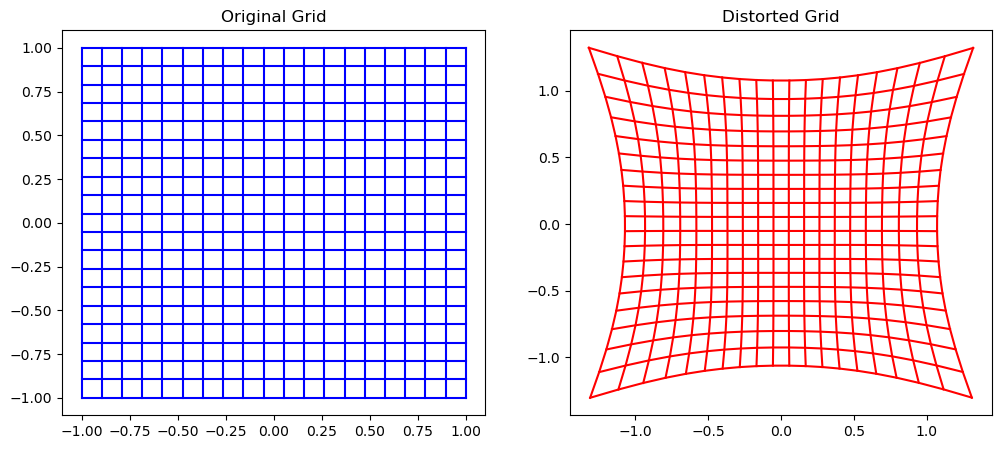

In [30]:
import matplotlib.pyplot as plt
import numpy as np

k1 = -0.015640236  # 较小的负值，表示轻微的桶形畸变
k2 = 0.086401022   # 正值，用于修正高阶畸变
# k2 = 0.166401022   # 正值，用于修正高阶畸变
p1 = 0.002232773   # 接近0，表示切向畸变很小
p2 = -0.000276212  # 接近0，表示切向畸变很小
# k3 = -1.234355939  # 高阶径向畸变修正
k3 = 0

def plot_distortion_effect():
    """绘制畸变效果示意图"""
    # 创建网格点
    x = np.linspace(-1, 1, 20)
    y = np.linspace(-1, 1, 20)
    # x = np.linspace(0, 1960, 1)
    # y = np.linspace(-1, 1080, 1)
    X, Y = np.meshgrid(x, y)
    
    # 计算畸变
    r2 = X**2 + Y**2
    r4 = r2**2
    r6 = r2**3
    k1 = -0.015640236
    
    Xd = X * (1 + k1*r2 + k2 * r4 + k3 * r6) + 2*p1*X*Y + p2*(r2 + 2*X**2)
    Yd = Y * (1 + k1*r2 + k2 * r4 + k3 * r6) + p1*(r2 + 2*Y**2) + 2*p2*X*Y
    
    # 绘制对比图
    plt.figure(figsize=(12, 5))
    
    plt.subplot(121)
    plt.plot(X, Y, 'b')
    plt.plot(X.T, Y.T, 'b')
    plt.title('Original Grid')
    
    plt.subplot(122)
    plt.plot(Xd, Yd, 'r')
    plt.plot(Xd.T, Yd.T, 'r')
    plt.title('Distorted Grid')
    
    plt.show()

plot_distortion_effect()